V18/7/14

## Dose Assessment for Building Products
### CEN TC 351 WG3 TG32

This is an impementation in R [1] of the dose estimation for building materials due to natural radionuclides. It's based on a methode used in an internal report of the finish office for radiation protection STUK [2], and was afterward the base of the famous index formula of the publication Radiation Protection 112 [3] by the European Commission.

The annual dose is estimated by a point kernel methode using Berger coefficients. The parameters were choosen to be compatible to the RP112, but the room size was adapted from the room used by CEN TC351 WG2 (without door and window). 

[1] R Development Core Team (2008). R: A language and environment for statistical computing. R Foundation for Statistical Computing, Vienna, Austria. ISBN 3-900051-07-0, URL http://www.R-project.org. The script was tested with R version 3.5.0 (Joy in Playing).

[2] Markkanen M. Radiation Dose Assessments for Materials with Elevated Natural Radioactivity. Report STUK-B-STO 32, Radiation and Nuclear Safety Authority – STUK, 1995.

[3] RP112: Radiological Protection Principles concerning the Natural Radioactivity of Building Materials

Remarks:

a) The absorption coefficient is scaled linear (as an approxiamtion) with the density of the material.

b) Here, the mean gamma energy for Radium is 0.810 MeV as used in RP112. The correct value is 0.860 MeV.

c) In RP112, the coefficient to harmonise the units was 5.77E-7. Here, it is 5.77E-10. It's still a open question, where's the difference come from. but nevertheless, the results of the calculations in the RP112 are correct.

A library which includs a funktion for numerical solution of 3d integrals, has to be loaded. (https://cran.r-project.org/package=cubature) This script was tested with V1.3-11.

In [1]:
library(cubature)

First, a fuction "walldose" with the width and height of the wall (cm), the distance from the wall (cm) as well as the thickness (cm) and density (kg/cm$^3$) is defined. The result is the annual dose per activity concentration in mSv/(Bq/kg) for radium, thorium and potassium separatelly.

Second, a function "roomdose" can be defined, wich add the dose of all six walls with the size of the WG2-room. Fixpoint is the center of the room. The free parameters are the thickness (cm) and the density (kg/cm$^3$) of the walls. Still, the result is the annual dose per activity concentration in mSv/(Bq/kg) for radium, thorium and potassium separatelly.

In [2]:
walldose <- function(x,y,z,d,rho) {
    gam <- c(2.12, 2.05, 0.356, 0.107) # emission probability
    mue <- c(0.166, 0.193, 0.0927, 0.124)*rho/2.350 # linear absorption coefficient of concrete, density corrected, 1/cm
    muer <- c(0.0285, 0.0295, 0.0217, 0.0257) # linear absorption coefficient of air, 10^(-5) cm^2/g
    Cbe <- c(1.161, 1.279, 0.734, 0.946) # Berger coefficient
    Dbe <- c(0.144, 0.190, 0.0234, 0.0755) # Berger coefficient
    E <- c(0.810, 0.587, 2.615, 1.461) # # average gamma energies in MeV 0.810 -> 0.860?
    conc <- c(1,1,1,1) # Activity oncentration, normalized to 1 Bq/kg
    wall <- c(x,y,d) 
    xp <- c(0,0,z) # Point at the middle of the wall at a distance
    
    itegr <-c(0,0,0,0)
    
    l <- function(x) {sqrt((xp[1]-x[1])^2+(xp[2]-x[2])^2+(xp[3]-x[3])^2)}
    s <- function(x) {abs(x[3]/(xp[3]-x[3]))*l(x)}
    
    inte1 <- function(x) {
        (1+Cbe[1]*mue[1]*s(x)*exp(Dbe[1]*mue[1]*s(x)))*exp(-mue[1]*s(x))/l(x)^2}
    inte2 <- function(x) {
        (1+Cbe[2]*mue[2]*s(x)*exp(Dbe[2]*mue[2]*s(x)))*exp(-mue[2]*s(x))/l(x)^2}
    inte3 <- function(x) {
        (1+Cbe[3]*mue[3]*s(x)*exp(Dbe[3]*mue[3]*s(x)))*exp(-mue[3]*s(x))/l(x)^2}
    inte4 <- function(x) {
    (1+Cbe[4]*mue[4]*s(x)*exp(Dbe[4]*mue[4]*s(x)))*exp(-mue[4]*s(x))/l(x)^2}
    
    itegr[1] <- adaptIntegrate(inte1, c(-wall[1]/2,-wall[2]/2,-wall[3]),c(wall[1]/2,wall[2]/2,0))$integral
    itegr[2] <- adaptIntegrate(inte2, c(-wall[1]/2,-wall[2]/2,-wall[3]),c(wall[1]/2,wall[2]/2,0))$integral
    itegr[3] <- adaptIntegrate(inte3, c(-wall[1]/2,-wall[2]/2,-wall[3]),c(wall[1]/2,wall[2]/2,0))$integral
    itegr[4] <- adaptIntegrate(inte4, c(-wall[1]/2,-wall[2]/2,-wall[3]),c(wall[1]/2,wall[2]/2,0))$integral
    
    dummy <- 0.7*7000*1000*(5.77e-10)/4/pi*rho*conc*gam*muer*E*itegr
    Dose <- c(dummy[1], dummy[2]+dummy[3],dummy[4])
    Dose
}

In [3]:
roomdose <- function(d,rho) {
    w1 <- 2*walldose(400,300,125,d,rho)
    w2 <- 2*walldose(400,250,150,d,rho)
    w3 <- 2*walldose(300,250,200,d,rho)
    w1+w2+w3
}

In a first test, the annual dose is calculated according to the first example of the TG32-report TR17113: Thickness 20 cm, density 2,350 kg/cm$^3$, C$_{Ra}$ = C$_{Th}$ = 80 Bq/kg, C$_{K}$ = 800 Bq/kg. A background of 0,29 mSv is considered as the population weighted average for Europe based on data of UNSCEAR. 

In [4]:
test = roomdose(20,2.350)

In [5]:
(80*test[1]+80*test[2]+800*test[3])-0.29

[1] 0.7677834

The annual dose in addition to the background is therefore estimated to 0,77 mSv.

In a second test, the dependencies of the dose in relation to the thickness and to the density is estimated. in the first plot, the density of the Material is 2,350 kg/m$^3$ resp. 800 kg/cm$^3$ (dashed lines). 

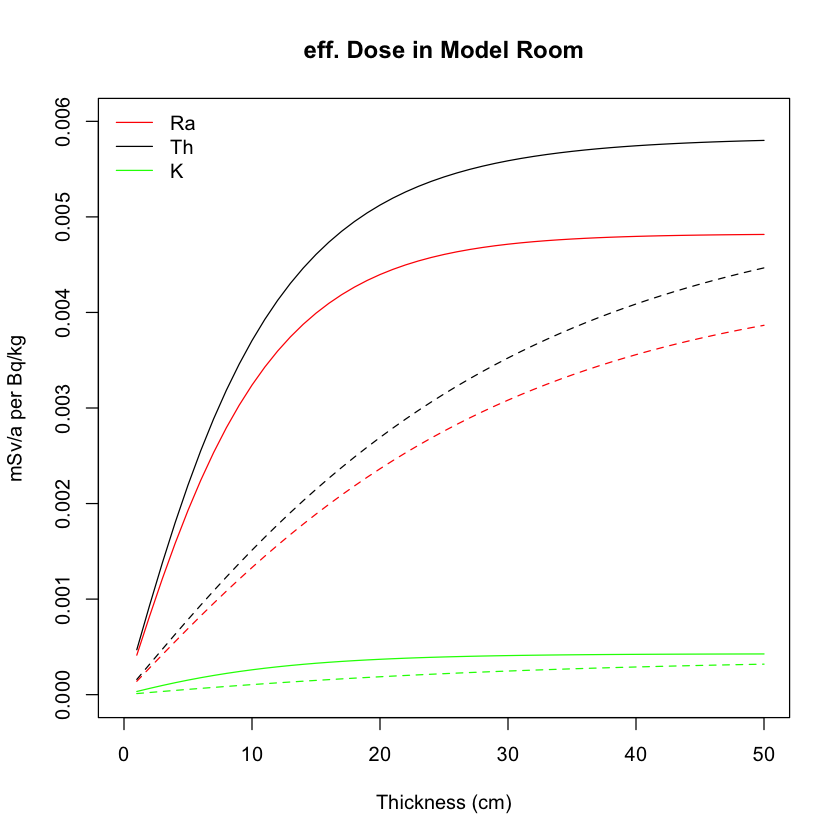

In [6]:
N <- 50
q <- array(0, dim=c(N,3))
p <- array(0, dim=c(N,3))
x <- array(0, dim=c(N))
for (i in 1:N){x[i] <- i; q[i,] <- roomdose(i,2.350); p[i,] <- roomdose(i,0.800)}

plot(x, q[,1], main="eff. Dose in Model Room", xlab="Thickness (cm)", 
     ylab="mSv/a per Bq/kg", xlim=c(0,N), ylim=c(0,0.006), type="l", col="red")
lines(x,q[,2], col="black")
lines(x,q[,3], col="green")
lines(x,p[,1], col="red", lty  = "dashed")
lines(x,p[,2], col="black", lty  = "dashed")
lines(x,p[,3], col="green", lty  = "dashed")

legend("topleft", c("Ra","Th","K"), col=c('red','black','green'), lty=1, bty="n")



Now, the thickness is fixed to 20 cm:

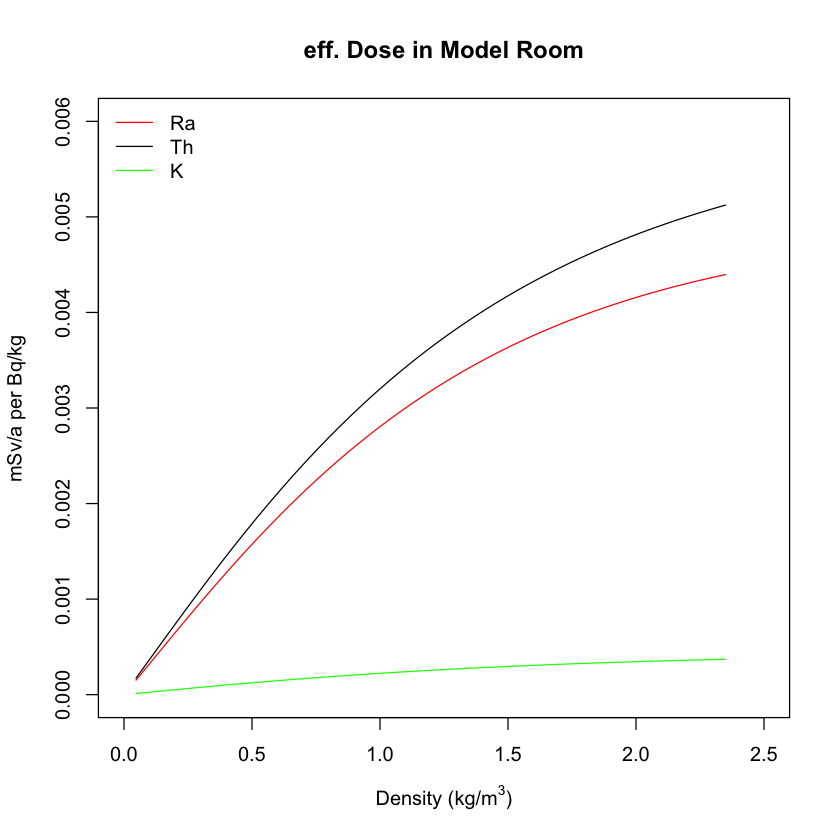

In [7]:
N <- 50
q <- array(0, dim=c(N,3))
x <- array(0, dim=c(N))
for (i in 1:N){x[i]<-2.350*i/N; q[i,]<- roomdose(20,2.350*i/N)}
plot(x,q[,2], main="eff. Dose in Model Room", 
     xlab=expression("Density (kg/m"^3*")"), 
     ylab="mSv/a per Bq/kg", xlim=c(0,2.5), ylim=c(0,0.006), type="l")
lines(x,q[,1], col="red")
lines(x,q[,3], col="green")
legend("topleft", c("Ra", "Th", "K"), lty=1, col=c('red','black','green'), bty='n')



From the plot, it can be evaluated that for most of the cases, a saturation can be assumed for values higher than ca. 20 cm in thickness and ca. 2.350 kg/cm$^3$ resp. ca. 50 kg/cm$^2$ for the mass per unit area. 

The next step ist to combine the two dependencies into one contour plot. 

The number of steps N can be choosen between about 20 and 50. 

In [8]:
n = 50 # Number of steps
Ra <- array(0, dim=c(n,n))
Th <- array(0, dim=c(n,n))
K <- array(0, dim=c(n,n))
dummy <- array(0, dim=c(3))

 for (i in 1:n){
     for (j in 1:n){
         dummy <- roomdose(40*i/n,2.50*j/n)
         Ra[i,j] <- dummy[1]
         Th[i,j] <- dummy[2]
         K[i,j] <- dummy[3]
     }
 }

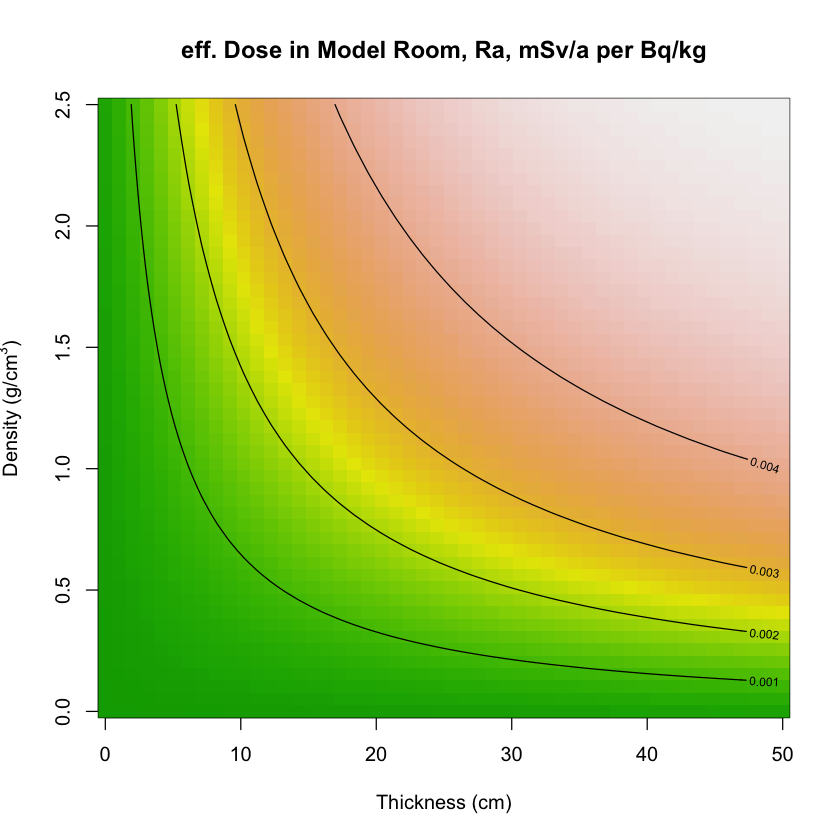

In [9]:
 q2 <- seq(0, 2.5, len = n)
 q1 <- seq(0, 50, len = n) 
 image(q1, q2, Ra, col = terrain.colors(256), axes = TRUE,
       main = "eff. Dose in Model Room, Ra, mSv/a per Bq/kg", xlab = "Thickness (cm)",
       ylab=expression("Density (g/cm"^3*")"))
 contour(q1, q2, Ra, levels = c(0.001,0.002,0.003,0.004), add = TRUE)

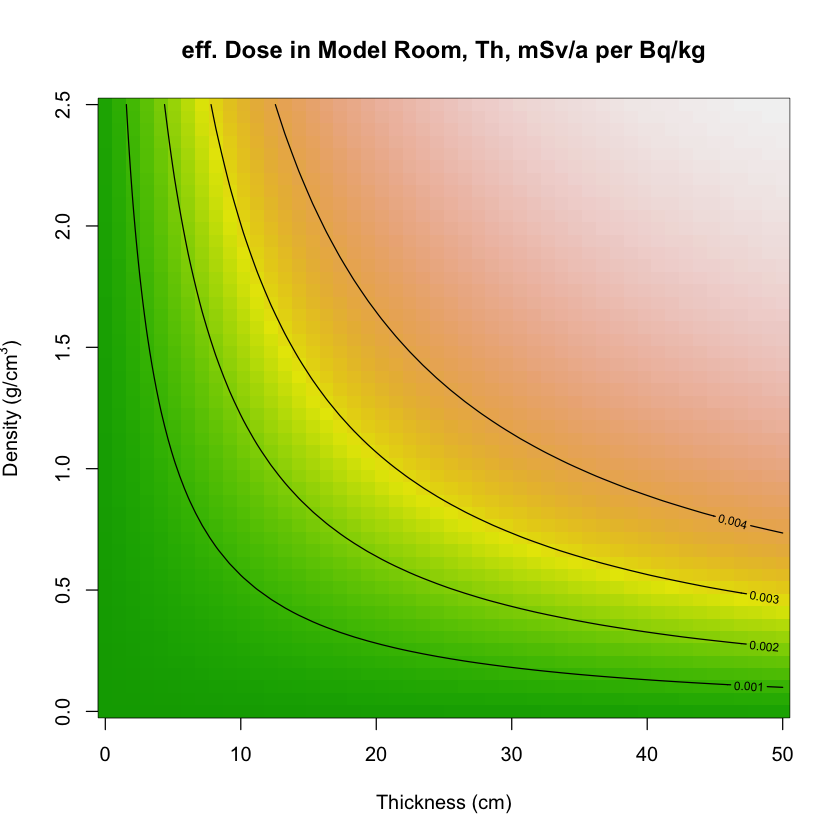

In [10]:
 image(q1, q2, Th, col = terrain.colors(256), axes = TRUE,
       main = "eff. Dose in Model Room, Th, mSv/a per Bq/kg", xlab = "Thickness (cm)",
       ylab=expression("Density (g/cm"^3*")"))
 contour(q1, q2, Th, levels = c(0.001,0.002,0.003,0.004), add = TRUE)

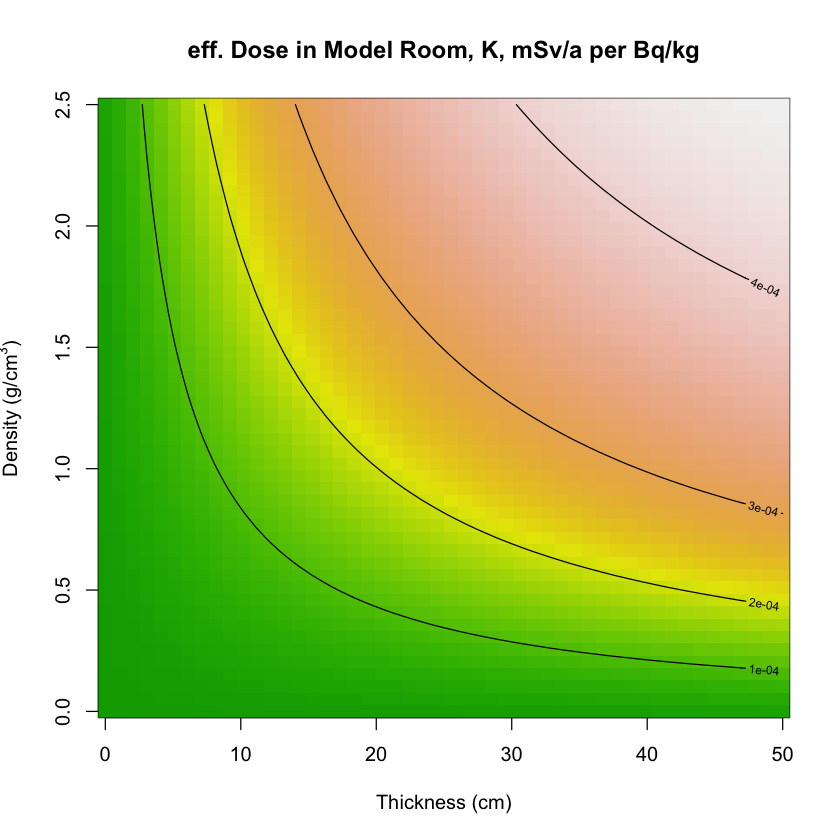

In [11]:
 image(q1, q2, K, col = terrain.colors(256), axes = TRUE,
       main = "eff. Dose in Model Room, K, mSv/a per Bq/kg", xlab = "Thickness (cm)",
       ylab=expression("Density (g/cm"^3*")"))
 contour(q1, q2, K, levels = c(0.0001,0.0002,0.0003,0.0004), add = TRUE)

The isolines look like rectangular hyperbola, witch propose that the dose is a function of the product of density and thickness (aka mass per unit area). To test this assumption, the dose is plotted for different thickness but constant masses per unit area. The isolines should be parallels.

In [12]:
n <- 50
Ra_FD <- array(0, dim=c(n,n))
Th_FD <- array(0, dim=c(n,n))
K_FD <- array(0, dim=c(n,n))
dummy <- array(0, dim=c(3))

for (i in 1:n){
    for (j in 1:n){
        dummy <- roomdose(50*i/n,2.5*j/i)
        Ra_FD[i,j] <- dummy[1]
        Th_FD[i,j] <- dummy[2]
        K_FD[i,j] <- dummy[3]
    }
}

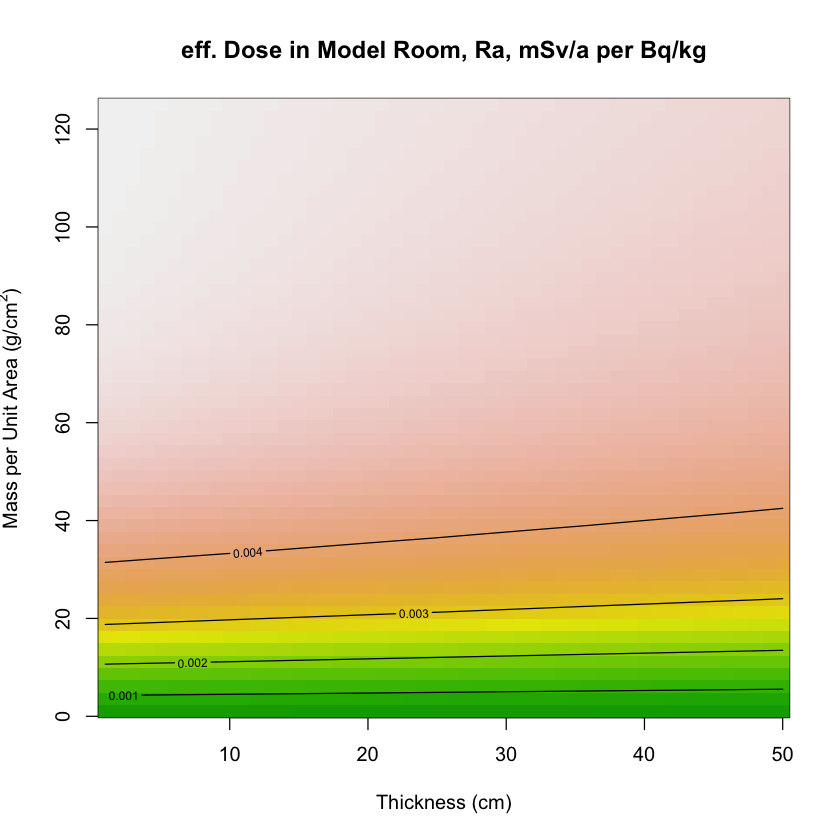

In [13]:
q1 <- seq(1, 50, len = n)
q2 <- seq(1, 125, len = n) 
image(q1, q2, Ra_FD, col = terrain.colors(256), axes = TRUE,
      main = "eff. Dose in Model Room, Ra, mSv/a per Bq/kg",
      xlab = "Thickness (cm)", ylab=expression("Mass per Unit Area (g/cm"^2*")"))
contour(q1, q2, Ra_FD, levels = c(0.001,0.002,0.003,0.004), add = TRUE)

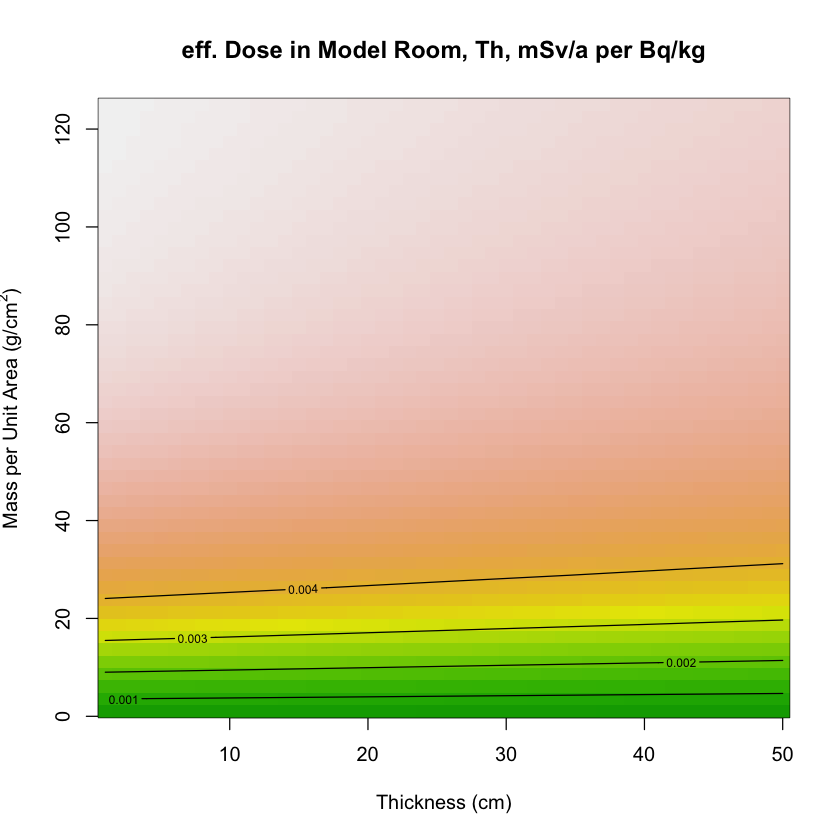

In [14]:
image(q1, q2, Th_FD, col = terrain.colors(256), axes = TRUE,
      main = "eff. Dose in Model Room, Th, mSv/a per Bq/kg",
      xlab = "Thickness (cm)", ylab=expression("Mass per Unit Area (g/cm"^2*")"))
contour(q1, q2, Th_FD, levels = c(0.001,0.002,0.003,0.004), add = TRUE)

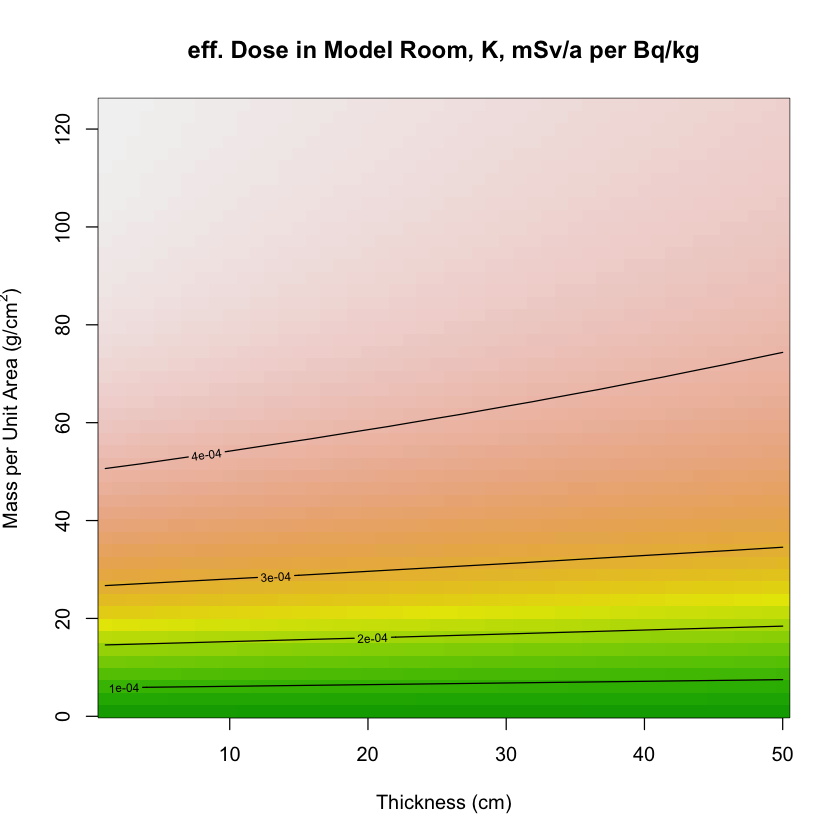

In [15]:
image(q1, q2, K_FD, col = terrain.colors(256), axes = TRUE,
      main = "eff. Dose in Model Room, K, mSv/a per Bq/kg",
      xlab = "Thickness (cm)", ylab=expression("Mass per Unit Area (g/cm"^2*")"))
contour(q1, q2, K_FD, levels = c(0.0001,0.0002,0.0003,0.0004), add = TRUE)

Lets find a suitable fit for a simplified calculation. From the parameter space, values from the midrange was choosen, e.g. a thickness of 20cm.

Some preparation for the needed data:

In [16]:
# preparing the data for the fits
Ra_FD20 <- array(0,dim=c(n))
Th_FD20 <- array(0,dim=c(n))
K_FD20 <- array(0,dim=c(n))

# dat for d=20cm
Ra_FD20 <- Ra_FD[20,]
Th_FD20 <- Th_FD[20,]
K_FD20 <- K_FD[20,]

q2 <- seq(1, 125, len = n) 

Radf <- data.frame(q2,Ra_FD20)
Thdf <- data.frame(q2,Th_FD20)
Kdf <- data.frame(q2,K_FD20)

The first tested approximation is a logathmical fit. 

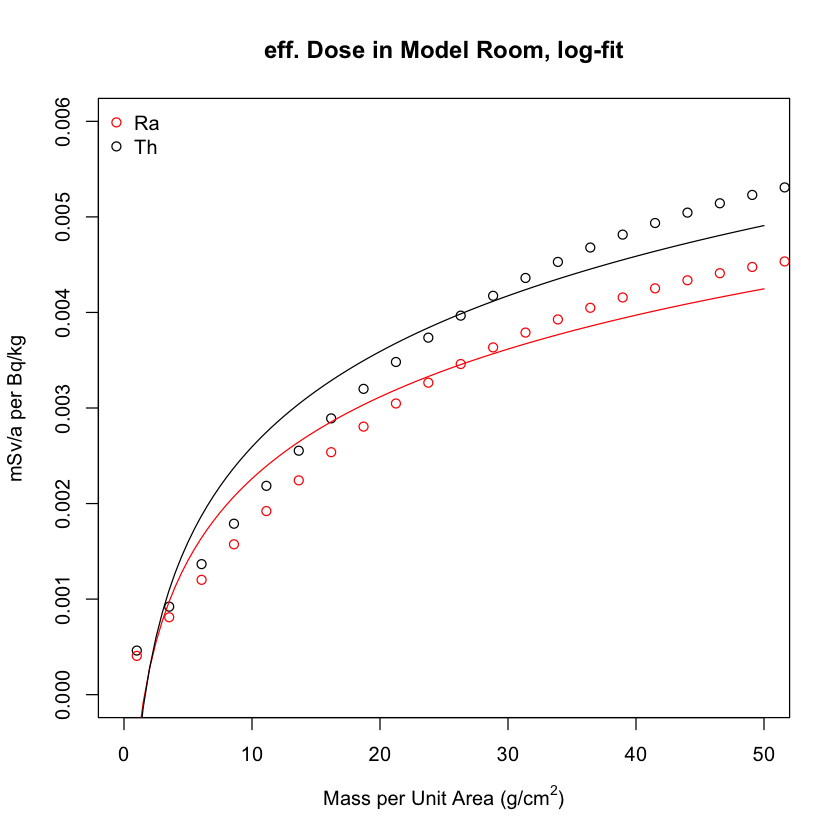

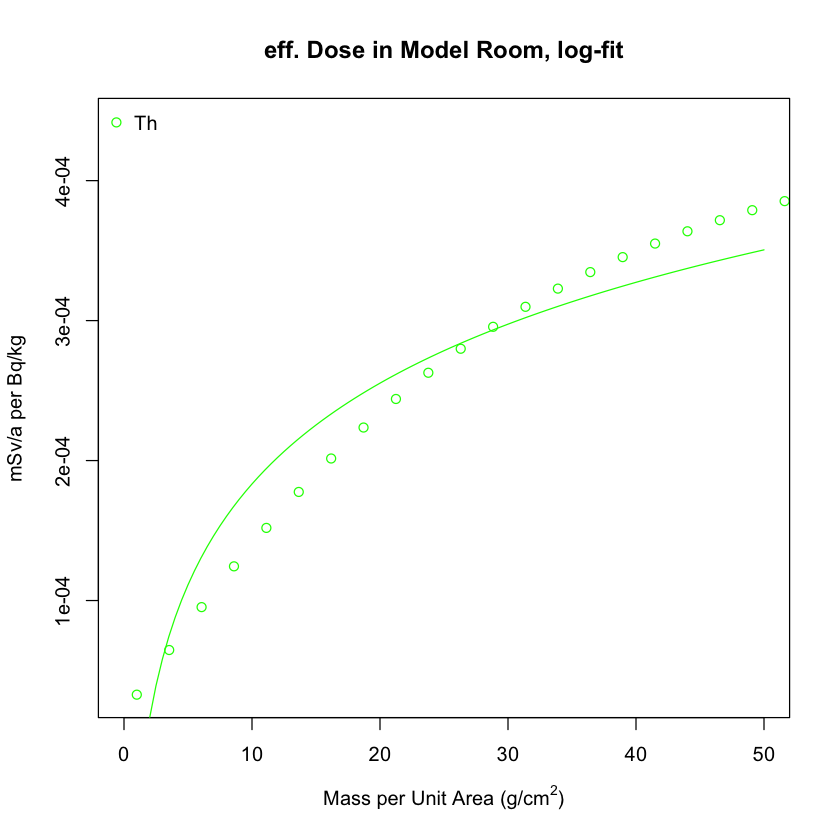

In [17]:
# logarithmical fit
# first plot the data
plot(q2,Th_FD20, main="eff. Dose in Model Room, log-fit", 
     xlab=expression("Mass per Unit Area (g/cm"^2*")"), ylab="mSv/a per Bq/kg", 
     ylim=c(0,0.006), xlim=c(0,50))
points(q2,Ra_FD20, col="red")
legend("topleft", c("Ra", "Th"), pch=c(1,1,1), col=c('red','black'), bty='n')

# do the fit
RalogEstimation <- lm(Ra_FD20 ~ log(q2), data=Radf, c(1:20))
# and plot the fitted curve
curve(coef(RalogEstimation)[1]+coef(RalogEstimation)[2]*log(x),add=TRUE, col="red")

ThlogEstimation <- lm(Th_FD20 ~ log(q2), data=Thdf, c(1:20))
curve(coef(ThlogEstimation)[1]+coef(ThlogEstimation)[2]*log(x),add=TRUE, col="black")

plot(q2,K_FD20, main="eff. Dose in Model Room, log-fit", 
     xlab=expression("Mass per Unit Area (g/cm"^2*")"), ylab="mSv/a per Bq/kg", 
     col="green", xlim=c(0,50))
legend("topleft", c("Th"), pch=c(1,1,1), col=c('green'), bty='n')

KlogEstimation <- lm(K_FD20 ~ log(q2), data=Kdf, c(1:20))
curve(coef(KlogEstimation)[1]+coef(KlogEstimation)[2]*log(x),add=TRUE, col="green")

In [18]:
# print the parameters
coef(RalogEstimation)
coef(ThlogEstimation)
coef(KlogEstimation)

(Intercept)       log(q2) 
-0.0005810168  0.0012341297

(Intercept)       log(q2) 
-0.0007182902  0.0014384388

(Intercept)       log(q2) 
-5.604173e-05  1.039331e-04

Lets try a better one: a linear quadratic fit

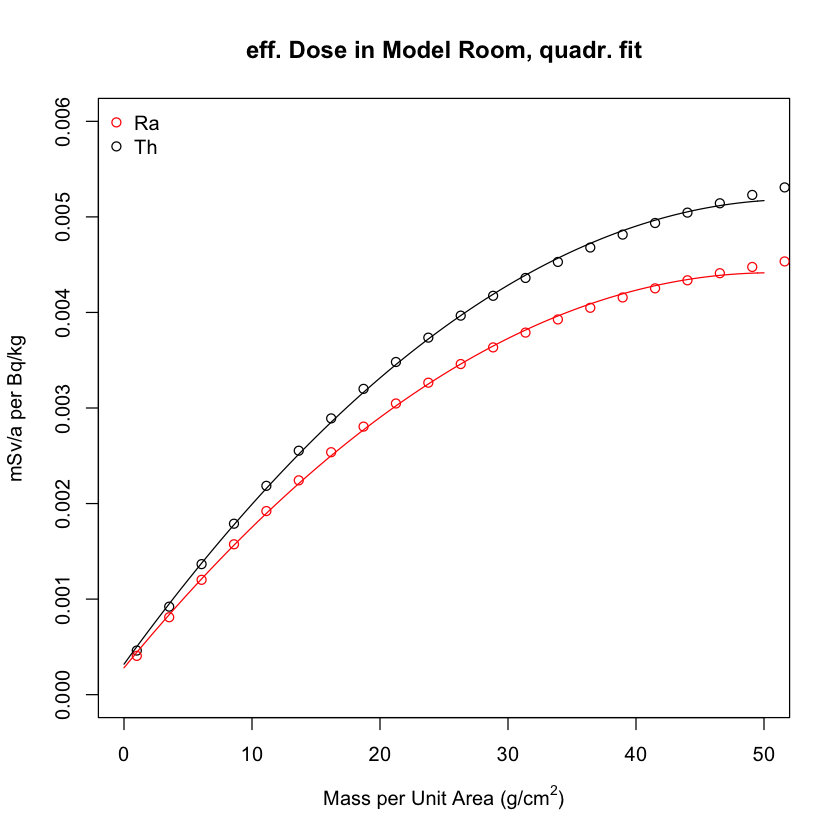

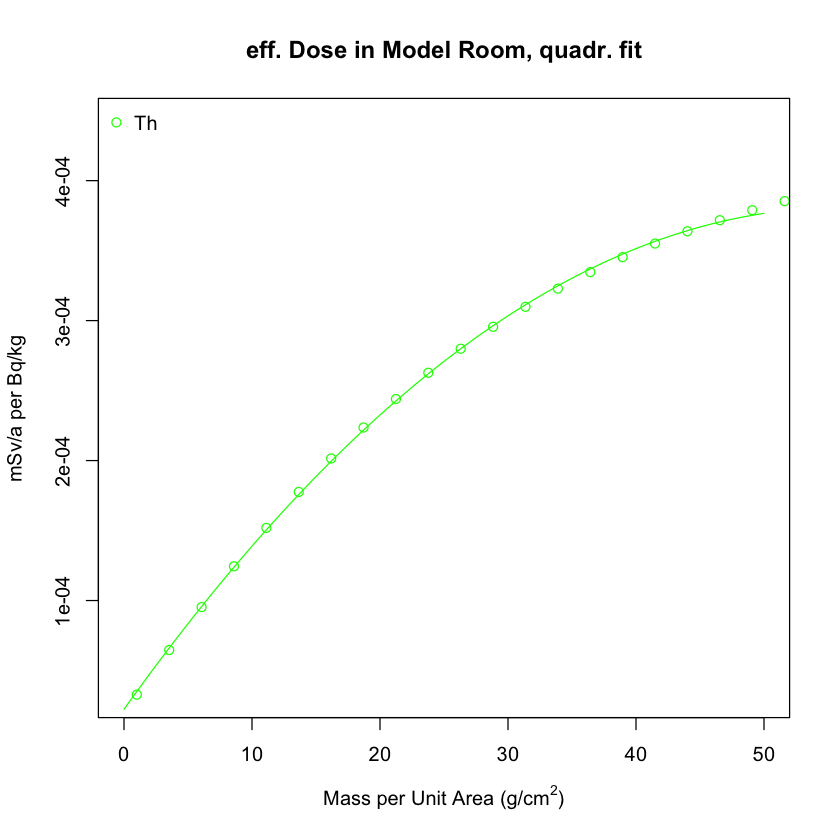

In [19]:
plot(q2,Th_FD20, main="eff. Dose in Model Room, quadr. fit", 
     xlab=expression("Mass per Unit Area (g/cm"^2*")"), ylab="mSv/a per Bq/kg", 
     ylim=c(0,0.006), xlim=c(0,50))
points(q2,Ra_FD20, col="red")
legend("topleft", c("Ra", "Th"), pch=c(1,1,1), col=c('red','black'), bty='n')

RaquaEstimation <- lm(Ra_FD20 ~ q2 + I(q2^2), data=Radf, c(1:20))
curve(coef(RaquaEstimation)[1]+coef(RaquaEstimation)[2]*x+
      coef(RaquaEstimation)[3]*x^2,add=TRUE, col="red")

ThquaEstimation <- lm(Th_FD20 ~ q2 + I(q2^2), data=Thdf, c(1:20))
curve(coef(ThquaEstimation)[1]+coef(ThquaEstimation)[2]*x+
      coef(ThquaEstimation)[3]*x^2,add=TRUE, col="black")

plot(q2,K_FD20, main="eff. Dose in Model Room, quadr. fit", 
     xlab=expression("Mass per Unit Area (g/cm"^2*")"), ylab="mSv/a per Bq/kg", 
     col="green", xlim=c(0,50))
legend("topleft", c("Th"), pch=c(1,1,1), col=c('green'), bty='n')

KquaEstimation <- lm(K_FD20 ~ q2 + I(q2^2), data=Kdf, c(1:20))
curve(coef(KquaEstimation)[1]+coef(KquaEstimation)[2]*x+
      coef(KquaEstimation)[3]*x^2,add=TRUE, col="green")

In [20]:
# again the parameters
coef(RaquaEstimation)
coef(ThquaEstimation)
coef(KquaEstimation)

(Intercept)            q2       I(q2^2) 
 2.808616e-04  1.632446e-04 -1.611405e-06

(Intercept)            q2       I(q2^2) 
 3.192128e-04  1.849216e-04 -1.757956e-06

(Intercept)            q2       I(q2^2) 
 2.230357e-05  1.279705e-05 -1.142229e-07

Lets use this fit to recalculate the example above:

In [21]:
RaD<-function(x) {coef(RaquaEstimation)[1]+coef(RaquaEstimation)[2]*x+
                  coef(RaquaEstimation)[3]*x^2}
ThD<-function(x) {coef(ThquaEstimation)[1]+coef(ThquaEstimation)[2]*x+
                  coef(ThquaEstimation)[3]*x^2}
KD<-function(x) {coef(KquaEstimation)[1]+coef(KquaEstimation)[2]*x+
                 coef(KquaEstimation)[3]*x^2}

RaD(46)*80+ThD(46)*80+KD(46)*800-0.29

(Intercept) 
  0.7643096

The annual dose in addition tho the background is therefore estimated to 0.76 mSv, compared to 0.77 mSv as calculated at the beginning.


As the finale result, the dose estimation in form as a refined index formular corrected to the density (kg/m$^3$) and thicknass (m) can be expressed as:

$$
D=\left[
\begin{array}{r}
    [281 + 16.3 \rho d - 0.0161(\rho d)^2]\cdot C_{Ra}\\
    +[319 + 18.5 \rho d - 0.0178(\rho d)^2]\cdot C_{Th}\\
    +[22.3 + 1.28 \rho d - 0.00114(\rho d)^2]\cdot C_{K}\\
\end{array}
\right]\cdot 10^{-6} \:\mbox{mSv}
-0,29 \:\mbox{mSv}$$

This formula is valid up to a mass per unit area of 500 kg/m$^2$. Due to the self‐attenuation the dose resulting from materials with higher mass per unit areas stay sufficiently constant. Therefore for those materials the dose can be estimated using a maximum value of 500 kg/m$^2$.

It was discussed that in the case of zero thickness or density this fit leads to a non vanishing dose, due to the constant terms of the fits whitch are clearly an artefact of the approximations and to the fit. As an alternatve, the fit can be forced to avoid these terms. 

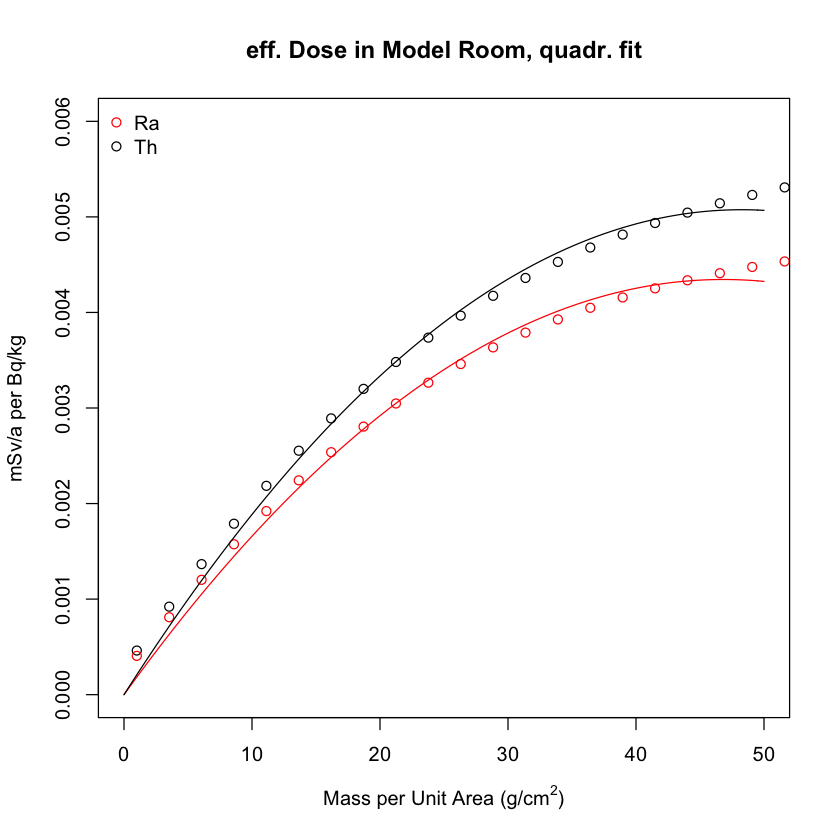

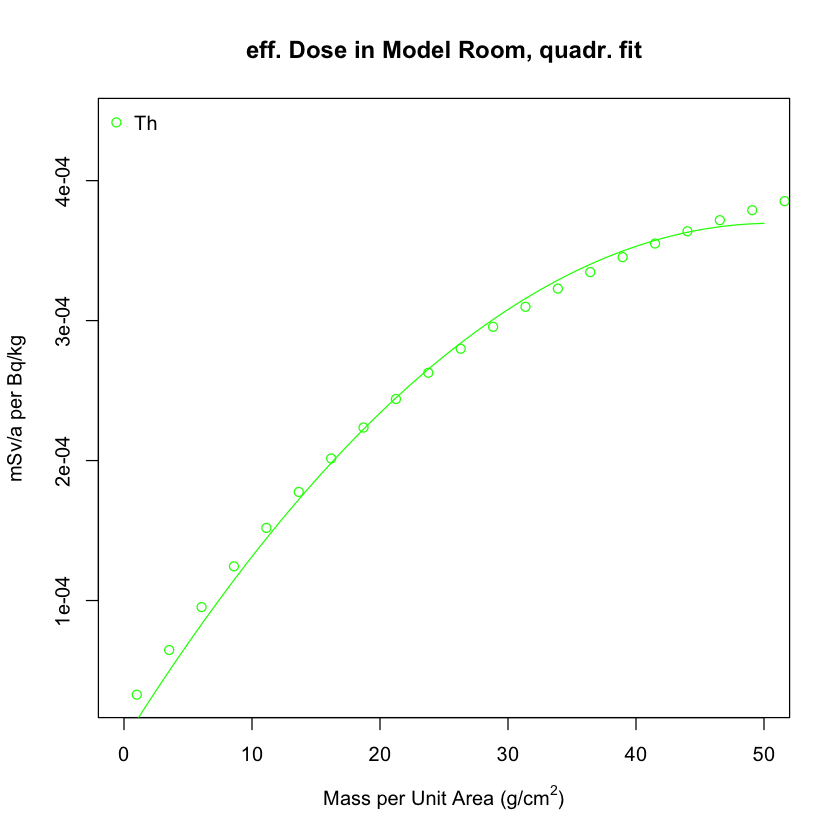

In [22]:
plot(q2,Th_FD20, main="eff. Dose in Model Room, quadr. fit", 
     xlab=expression("Mass per Unit Area (g/cm"^2*")"), ylab="mSv/a per Bq/kg", 
     ylim=c(0,0.006), xlim=c(0,50))
points(q2,Ra_FD20, col="red")
legend("topleft", c("Ra", "Th"), pch=c(1,1,1), col=c('red','black'), bty='n')

RaquaEstimationZero <- lm(Ra_FD20 ~ -1 + q2 + I(q2^2), data=Radf, c(1:20))
curve(coef(RaquaEstimationZero)[1]*x+
      coef(RaquaEstimationZero)[2]*x^2,add=TRUE, col="red")

ThquaEstimationZero <- lm(Th_FD20 ~ -1 + q2 + I(q2^2), data=Thdf, c(1:20))
curve(coef(ThquaEstimationZero)[1]*x+
      coef(ThquaEstimationZero)[2]*x^2,add=TRUE, col="black")

plot(q2,K_FD20, main="eff. Dose in Model Room, quadr. fit", 
     xlab=expression("Mass per Unit Area (g/cm"^2*")"), ylab="mSv/a per Bq/kg", 
     col="green", xlim=c(0,50))
legend("topleft", c("Th"), pch=c(1,1,1), col=c('green'), bty='n')

KquaEstimationZero <- lm(K_FD20 ~ -1 + q2 + I(q2^2), data=Kdf, c(1:20))
curve(coef(KquaEstimationZero)[1]*x+
      coef(KquaEstimationZero)[2]*x^2,add=TRUE, col="green")

Again the parameters:

In [23]:
coef(RaquaEstimationZero)
coef(ThquaEstimationZero)
coef(KquaEstimationZero)

q2       I(q2^2) 
 1.856177e-04 -1.982405e-06

q2       I(q2^2) 
 2.103496e-04 -2.179615e-06

q2       I(q2^2) 
 1.457372e-05 -1.436844e-07

And the test with the first sample:

In [24]:
RaD0<-function(x) {coef(RaquaEstimationZero)[1]*x+
                  coef(RaquaEstimationZero)[2]*x^2}
ThD0<-function(x) {coef(ThquaEstimationZero)[1]*x+
                  coef(ThquaEstimationZero)[2]*x^2}
KD0<-function(x) {coef(KquaEstimationZero)[1]*x+
                 coef(KquaEstimationZero)[2]*x^2}

RaD0(46)*80+ThD0(46)*80+KD0(46)*800-0.29

q2 
0.755697

The fit and the approximation get worse. Therefore, I have rejected this solution.

In addition, some code to produce the bw-graphics used in the TR17113:

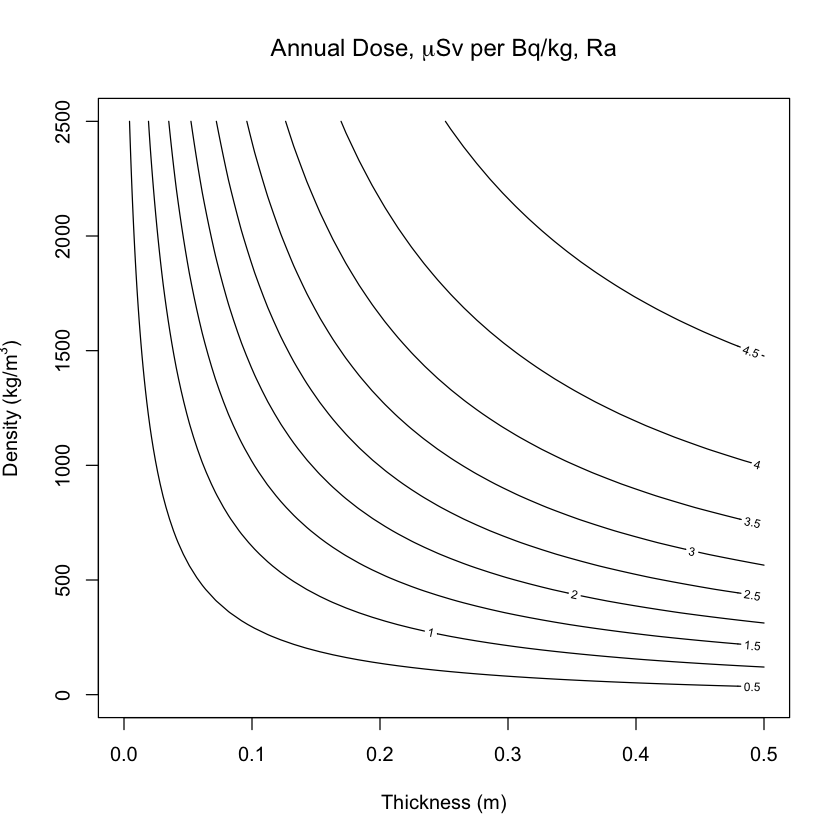

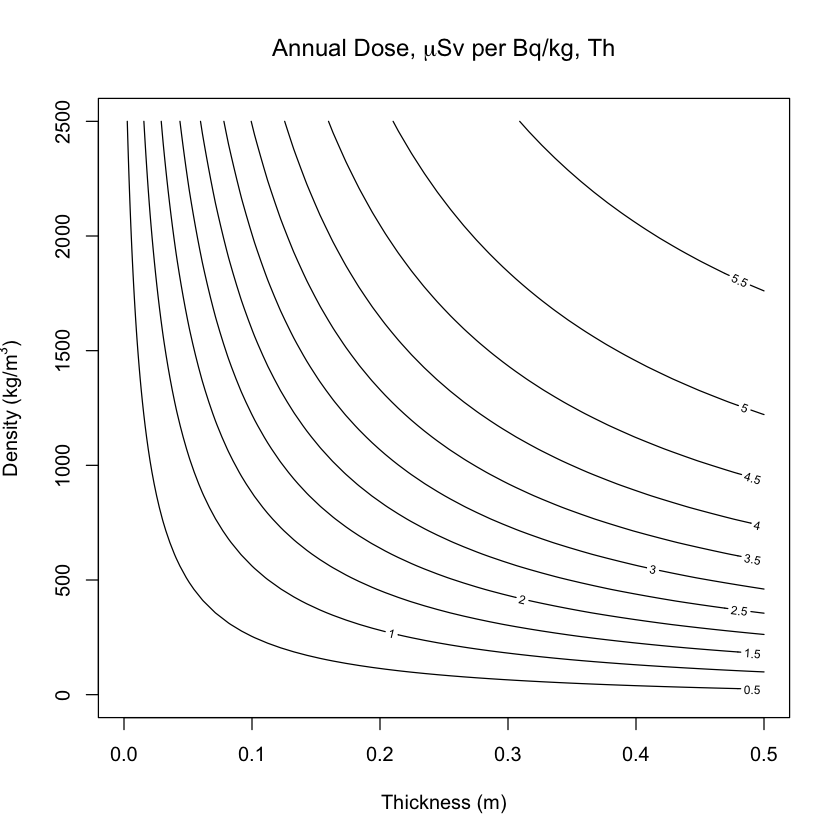

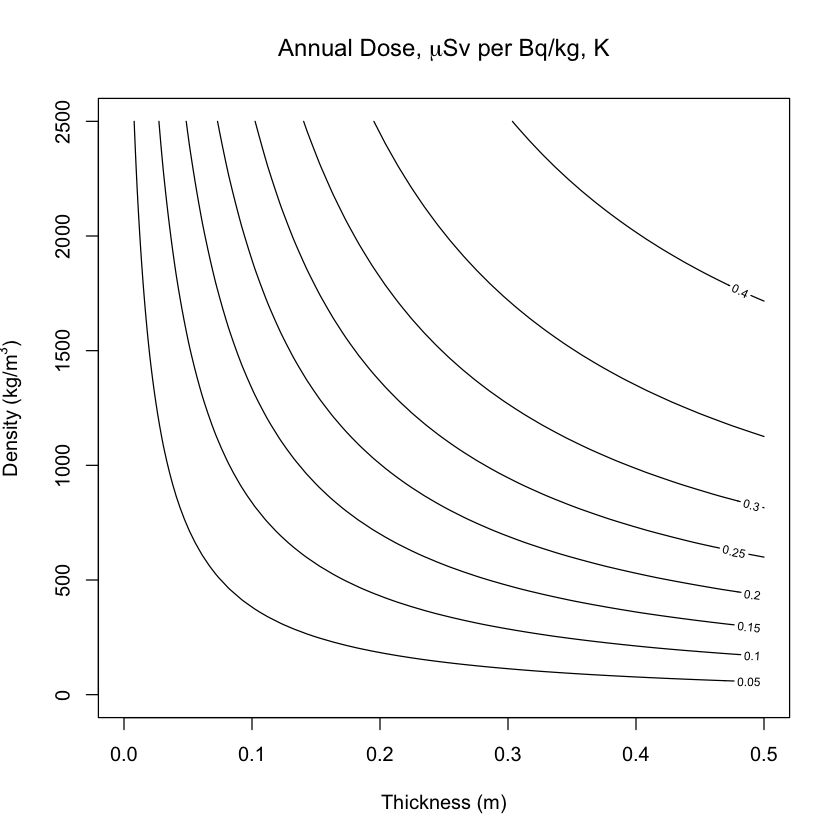

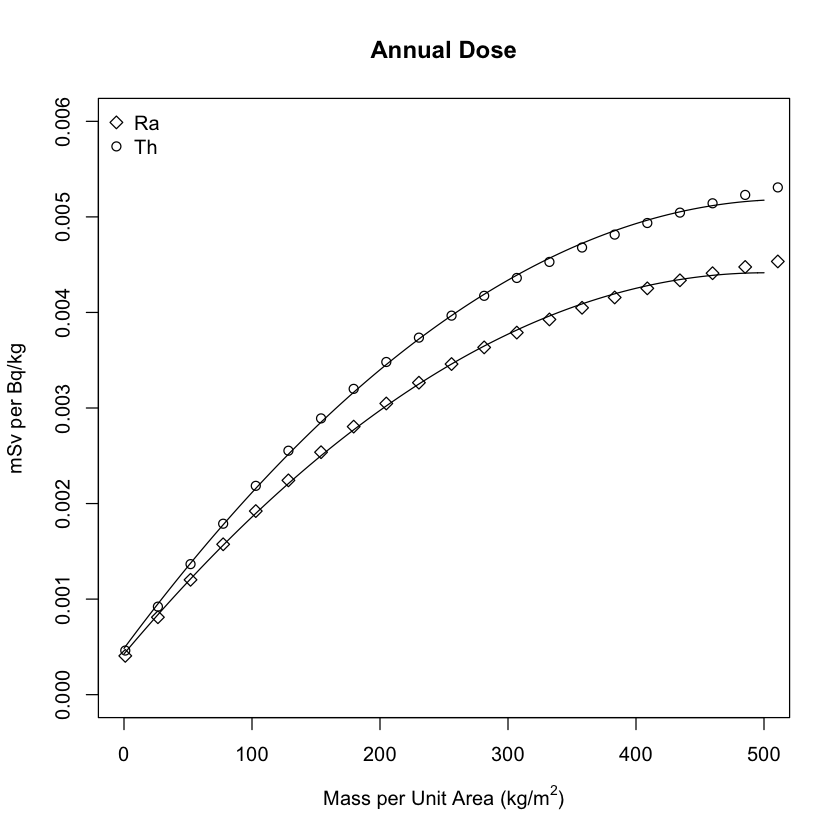

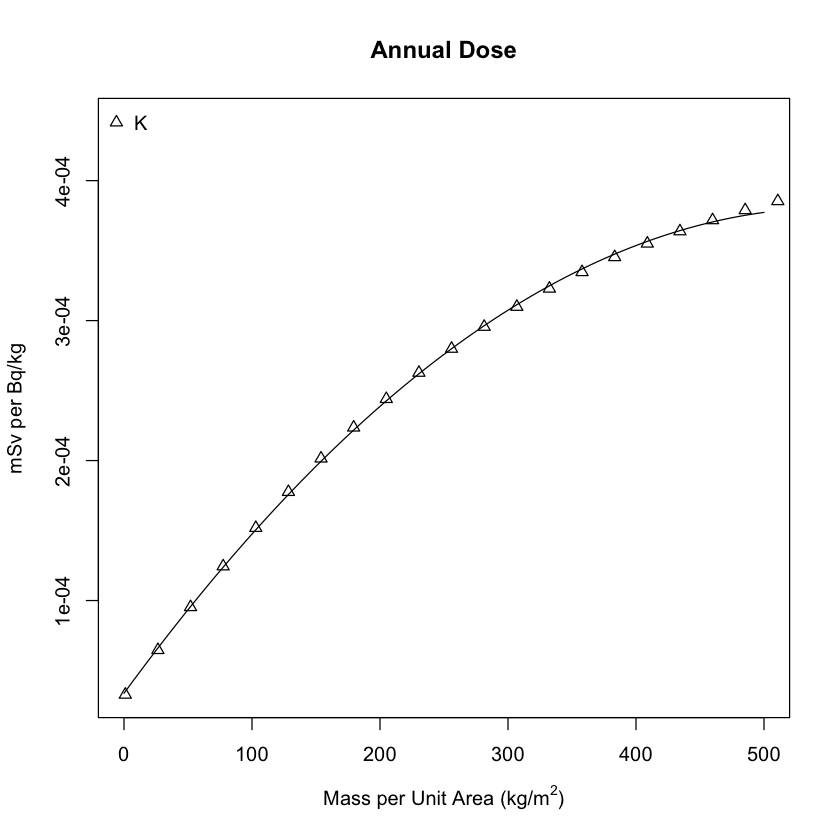

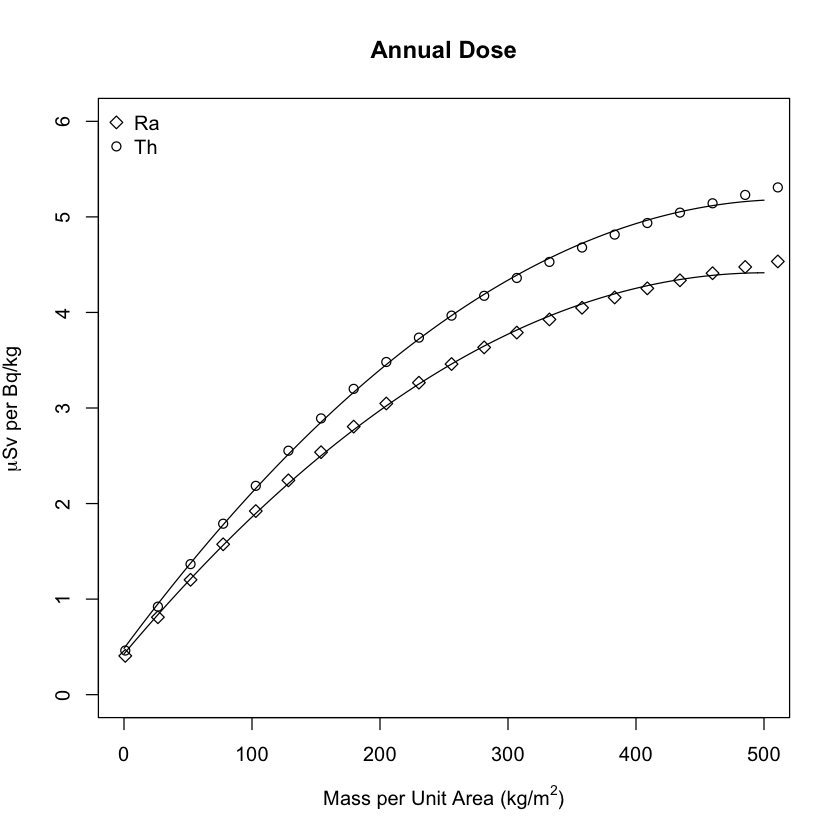

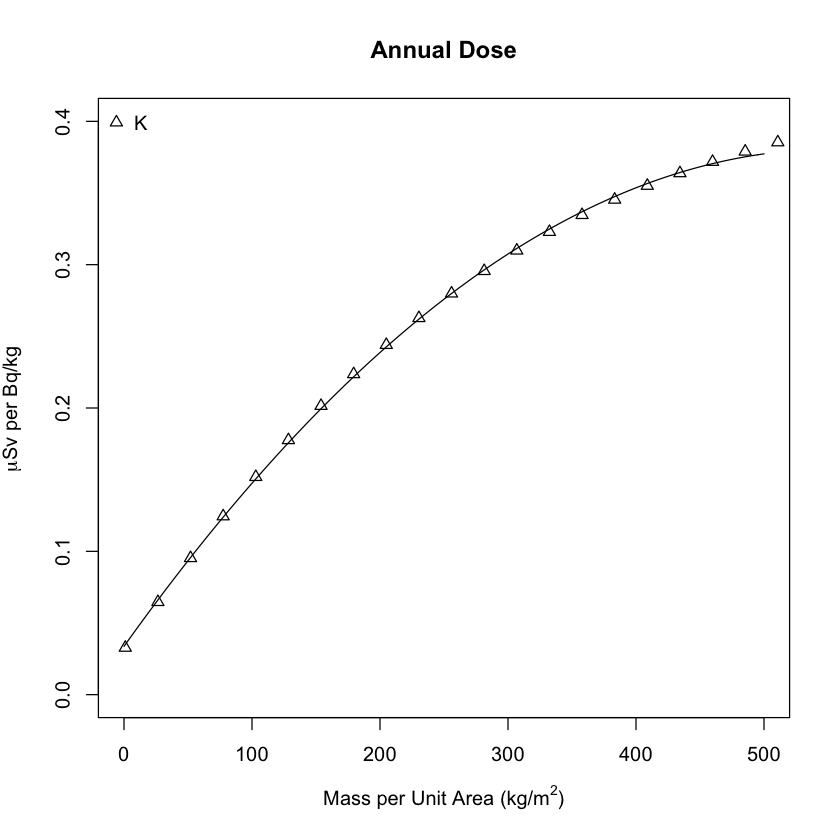

In [25]:
##########################################
# bw-Graphics, SI-Units
q2 <- seq(0, 2500, len = n)
q1 <- seq(0, 0.5, len = n) 
l <- seq(0,0.01, len=21)
l1 <- seq(0,0.001, len=21)
contour(q1, q2, 1000*Ra, levels = 1000*l, axes = TRUE, main = expression(paste(plain("Annual Dose, "),mu, plain("Sv per Bq/kg, Ra"))), xlab = "Thickness (m)", ylab=expression(paste(plain("Density (kg/"),m^3,plain(")"))))
contour(q1, q2, 1000*Th, levels = 1000*l, axes = TRUE, main = expression(paste(plain("Annual Dose, "),mu, plain("Sv per Bq/kg, Th"))), xlab = "Thickness (m)", ylab=expression(paste(plain("Density (kg/"),m^3,plain(")"))))
contour(q1, q2, 1000*K, levels = 1000*l1, axes = TRUE, main = expression(paste(plain("Annual Dose, "),mu, plain("Sv per Bq/kg, K"))), xlab = "Thickness (m)", ylab=expression(paste(plain("Density (kg/"),m^3,plain(")"))))

# quadratical Fit, s/w-plots

# preparing the data for the fits

q2 <- seq(1, 1250, len = n) 

Radf <- data.frame(q2,Ra_FD20)
Thdf <- data.frame(q2,Th_FD20)
Kdf <- data.frame(q2,K_FD20)

plot(q2,Th_FD20, main="Annual Dose", xlab=expression(paste(plain("Mass per Unit Area (kg/"),m^2,plain(")"))), ylab="mSv per Bq/kg", ylim=c(0,0.006), xlim=c(0,500))
points(q2,Ra_FD20, pch=5)
legend("topleft", c("Ra", "Th"), pch=c(5,1),bty="n")

RaquaEstimation <- lm(Ra_FD20 ~ q2 + I(q2^2), data=Radf, c(1:20))
curve(coef(RaquaEstimation)[1]+coef(RaquaEstimation)[2]*x+coef(RaquaEstimation)[3]*x^2,add=TRUE)

ThquaEstimation <- lm(Th_FD20 ~ q2 + I(q2^2), data=Thdf, c(1:20))
curve(coef(ThquaEstimation)[1]+coef(ThquaEstimation)[2]*x+coef(ThquaEstimation)[3]*x^2,add=TRUE, col="black")

plot(q2,K_FD20, main="Annual Dose", xlab=expression(paste(plain("Mass per Unit Area (kg/"),m^2,plain(")"))), ylab="mSv per Bq/kg", pch=2,xlim=c(0,500))
legend("topleft", c("K"), pch=2, bty='n')

KquaEstimation <- lm(K_FD20 ~ q2 + I(q2^2), data=Kdf, c(1:20))
curve(coef(KquaEstimation)[1]+coef(KquaEstimation)[2]*x+coef(KquaEstimation)[3]*x^2,add=TRUE)

# Mikrosievert as unit

q2 <- seq(1, 1250, len = n) 

Radf <- data.frame(q2,Ra_FD20)
Thdf <- data.frame(q2,Th_FD20)
Kdf <- data.frame(q2,K_FD20)

plot(q2,1000*Th_FD20, main="Annual Dose", xlab=expression(paste(plain("Mass per Unit Area (kg/"),m^2,plain(")"))), ylab=expression(paste(mu,plain("Sv per Bq/kg"))), ylim=c(0,6), xlim=c(0,500))
points(q2,1000*Ra_FD20, pch=5)
legend("topleft", c("Ra", "Th"), pch=c(5,1),bty="n")

RaquaEstimation <- lm(Ra_FD20 ~ q2 + I(q2^2), data=Radf, c(1:20))
curve(1000*(coef(RaquaEstimation)[1]+coef(RaquaEstimation)[2]*x+coef(RaquaEstimation)[3]*x^2),add=TRUE)

ThquaEstimation <- lm(Th_FD20 ~ q2 + I(q2^2), data=Thdf, c(1:20))
curve(1000*(coef(ThquaEstimation)[1]+coef(ThquaEstimation)[2]*x+coef(ThquaEstimation)[3]*x^2),add=TRUE, col="black")

plot(q2,1000*K_FD20, main="Annual Dose", xlab=expression(paste(plain("Mass per Unit Area (kg/"),m^2,plain(")"))), ylab=expression(paste(mu,plain("Sv per Bq/kg"))), pch=2, xlim=c(0,500), ylim=c(0,0.4))
legend("topleft", c("K"), pch=2, bty='n')

KquaEstimation <- lm(K_FD20 ~ q2 + I(q2^2), data=Kdf, c(1:20))
curve(1000*(coef(KquaEstimation)[1]+coef(KquaEstimation)[2]*x+coef(KquaEstimation)[3]*x^2),add=TRUE)